在这个教程中，你将会学到怎么对OD数据应用社区发现算法分析社区发现社区

<div class="alert alert-info"><h2>提供的基础数据是：</h2><p>

<br>
    GIS文件：<br>
    1.深圳行政区划<br>
    2.深圳栅格<br>
    <br>
    数据：<br>
    1.出租车GPS集计栅格OD<br>

</div>

# 基础理论

如果我们把栅格看作节点，而栅格与栅格之间的OD看成连接节点的边，那么出租车的OD信息就可以构建出一个联系网络Graph  

网络分析中将具有高度联系的节点的组合定义为社区：
>所谓社区是由网络中一些节点的集合构成，社区内部节点之间的连接边密度较高，不同社区节点之间的连接边密度相对较低  

借助社区发现算法可以将网络分解为不同的社区，进而研究其中的空间结构关系。

<img src="https://gitee.com/ni1o1/pygeo-tutorial/raw/master/resource/社区发现.png" style="width:1000px">

<img src="https://gitee.com/ni1o1/pygeo-tutorial/raw/master/resource/社区发现2.png" style="width:1000px">

# 读取基础数据

In [2]:
#导入必要的包
import pandas as pd
import numpy as np

#绘制图用的包
import matplotlib as mpl
import matplotlib.pyplot as plt

#geopandas包
import geopandas

#shapely包
from shapely.geometry import Point,Polygon,shape

## GIS数据

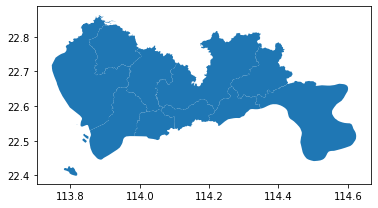

In [3]:
#行政区划数据
#读取shapefile文件
shp = r'shapefile\sz.shp'
xzqh = geopandas.GeoDataFrame.from_file(shp,encoding = 'utf-8')

#绘制看看长什么样
xzqh.plot()

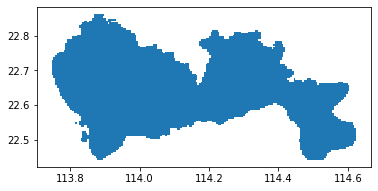

In [4]:
#栅格数据
#读取shapefile文件
shp = r'shapefile\grid\grid.shp'
grid = geopandas.GeoDataFrame.from_file(shp,encoding = 'gbk')

#绘制看看长什么样
grid.plot()

## 栅格OD数据

In [8]:
OD = pd.read_csv(r'data-sample\taxi_od_grid.csv')
OD.head(5)

,SLONCOL,SLATCOL,ELONCOL,ELATCOL,VehicleNum
0,63,17,65,16,298
1,75,21,74,19,275
2,63,18,65,16,235
3,76,21,74,19,173
4,65,17,63,18,172


In [6]:
OD.columns

Index(['SLONCOL', 'SLATCOL', 'ELONCOL', 'ELATCOL', 'VehicleNum'], dtype='object')

# 社区发现

## 整理数据

每个栅格是一个复杂网络中的一个节点，因此我们把节点信息创建一个表，在社区发现后还可以往表中加列代表节点的社区  
先把经纬度LONCOL和LATCOL搞成一个字段

输入OD表是

|SLONCOL | SLATCOL |ELONCOL | ELATCOL | VehicleNum(数量) |
| ----------- |-----------|-----------| ----------- |-----------|
|65|17|63|18|100|

输出grids表是  

|gird(由LONCOL和LATCOL得到)| id|
| ----------- |-----------|
|65,17|0|
|63,18|1|
|63,19|2|

In [ ]:
###########################你需要在下面写代码#############################












###################################################################################

In [12]:
###############################     答案   ##################################
OD['sgrid'] = OD['SLONCOL'].astype('str')+','+OD['SLATCOL'].astype('str')
OD['egrid'] = OD['ELONCOL'].astype('str')+','+OD['ELATCOL'].astype('str')
grids = list(OD['sgrid'])+list(OD['egrid'])
grids = list(set(grids))
grids = pd.DataFrame(grids)
grids.columns = ['grid']
grids['id'] = range(len(grids))
grids.head(5)
###################################################################################

,grid,id
0,"22,62",0
1,"23,29",1
2,"6,62",2
3,"98,50",3
4,"13,67",4


把重新编号的grid连到OD表上，得到OD_reindex表  
OD_reindex：

|oid| eid| VehicleNum|
| ----------- |-----------|-----------|
|1|0|100|
|0|1|200|
|1|2|300|

In [ ]:
###########################你需要在下面写代码#############################












###################################################################################

In [15]:
###############################     答案   ##################################
#连到OD表上
OD_reindex = OD[['sgrid','egrid','VehicleNum']]
grids.columns = ['sgrid','oid']
OD_reindex = pd.merge(OD_reindex,grids,on = 'sgrid')
grids.columns = ['egrid','did']
OD_reindex = pd.merge(OD_reindex,grids,on = 'egrid')
OD_reindex.head(5)
###################################################################################

,sgrid,egrid,VehicleNum,oid,did
0,"63,17","65,16",298,3201,2027
1,"75,21","65,16",139,3745,2027
2,"63,18","65,16",235,3264,2027
3,"76,21","65,16",89,2089,2027
4,"65,17","65,16",64,1353,2027


## 使用igraph包做社区发现

安装一下python-igraph包
>pip install python-igraph

In [17]:
#导入包
import numpy as np
from igraph import *

#提取边
eages = np.array(OD_reindex[['oid','did']])
eages = list(map(tuple, eages))

#提取边的权重
edge_weights = (np.array(OD_reindex['VehicleNum'])).tolist()

#创建网络
g = Graph()

#在网络中创建节点
g.add_vertices(len(grids))

#把边加入图中
g.add_edges(eages)

#为图中的边添加权重
for i in range(len(edge_weights)):
    g.es[i]["weight"]=edge_weights[i]

edge_weights = np.array(edge_weights)

In [21]:
#调包侠
#对网络应用社区发现的方法
g_clustered =g.community_multilevel(weights = edge_weights)

#计算结果的模块度
md = g_clustered.modularity

#将分组信息赋值到栅格信息表中
grids['group'] = g_clustered.membership

把grids的信息还原出LONCOL和LATCOL字段，以便后面匹配回grid

In [ ]:
###########################你需要在下面写代码#############################












###################################################################################

In [30]:
###############################     答案   ##################################
tmp = grids['egrid'].apply(lambda r:r.split(','))
grids['LONCOL'] = tmp.apply(lambda r:r[0]).astype('int')
grids['LATCOL'] = tmp.apply(lambda r:r[1]).astype('int')

###################################################################################

将grids（网络节点信息）与grid（空间信息gdf）匹配，得到gridtoplot变量，以便进行下一步的可视化

In [33]:
###########################你需要在下面写代码#############################












###################################################################################


,LONCOL,LATCOL,group,HBLON,HBLAT,geometry
0,22,62,26,113.856701,22.724378,"POLYGON ((113.8542648958734 22.7221299175918, ..."
1,23,29,26,113.861574,22.575990,"POLYGON ((113.8591375099626 22.57374194577984,..."
2,6,62,26,113.778739,22.724378,"POLYGON ((113.776303070446 22.7221299175918, 1..."
3,98,50,38,114.227020,22.670419,"POLYGON ((114.2245835666531 22.66817065511473,..."
4,13,67,26,113.812848,22.746861,"POLYGON ((113.8104113690705 22.74461294362391,..."


In [ ]:
###############################     答案   ##################################
gridtoplot = pd.merge(grids[['LONCOL','LATCOL','group']],grid,on = ['LONCOL','LATCOL'])
gridtoplot.head(5)

###################################################################################

In [35]:
# 绘图前，一定要确保变量为GeoDataFrame，而不是DataFrame
gridtoplot = geopandas.GeoDataFrame(gridtoplot)

# 可视化

对gridtoplot变量可视化，并用tab10这个colormap来显示

In [ ]:
###########################你需要在下面写代码#############################












###################################################################################


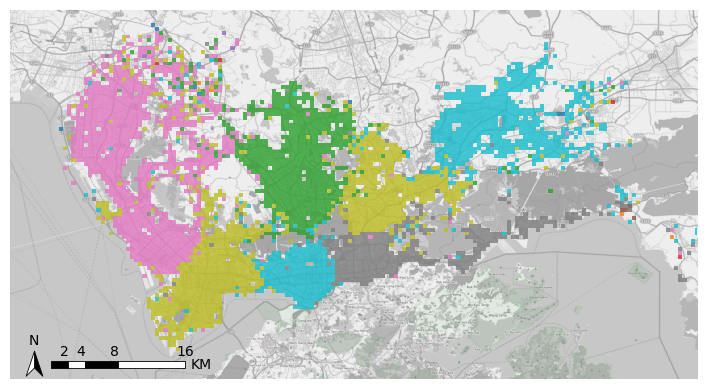

In [48]:

###############################     答案   ##################################

bounds = [113.7, 22.42, 114.5, 22.85]

import matplotlib as mpl
import matplotlib.pyplot as plt
import plot_map
import seaborn as sns
fig     = plt.figure(1,(8,8),dpi = 100)    
ax      = plt.subplot(111)
plt.sca(ax)
fig.tight_layout(rect = (0.05,0.1,1,0.9))

#背景
plot_map.plot_map(plt,bounds,zoom = 12,style = 4)

gridtoplot.plot(ax = ax,column = 'group',cmap = 'tab10',alpha = 0.8)

plt.axis('off')
plt.xlim(bounds[0],bounds[2])
plt.ylim(bounds[1],bounds[3])

# 加比例尺和指北针
plot_map.plotscale(ax,bounds = bounds,textsize = 10,compasssize = 1,accuracy = 2000,rect = [0.06,0.03])

plt.show()
###################################################################################

# 作业

尝试一下igraph包里的其他社区发现算法，并对比一下结果的差异